# New Hire - Contribute to HSA

Ensure new hires who enroll in  HDHP will also open and contribute to HSA within 30 days.

Predict  which new hires are likely to enroll in HDHP but are not likely to open and contribute to the HSA within 30 days.

For this analysis and modeling we are solely using *person_hm_choice_enrolled_integrated* (PHCE) table and we have tweaked the "not likely to open and contribute to the HSA within 30 days from *hire date*" to  "not likely to open and contribute to the HSA within 30 days from *first date when they did new hire enrollment in hdhp medical plan*".

-----
In this notebook, we will perform below steps
- Load pre-processed data
- Splitting the dataset into train (70%) and test (30%). Train set will be used to fit and transform the train set and transform test set 
- Transform above data to make it ready for ML model. This step include sub-steps
    - Rolling up levels of categorical variables
    - Imputing missing values of categorical variables by "Unknown"
    - Imputing missing values of numeric variables by median based on employment status
    - Handling data exceptions
- Visualize distribution of target variable w.r.t predictors
- Store tranformed training anf testing set in S3, which will be further used for ML modeling and evluation

<font color='red'>
We need to edit below two cells before running the whole script.
    
If not editted, data will be pulled and stored from S3 bucket as per given values.
</font>

### For Loading Pre-processed Data

In [2]:
# Mention the bucket name where raw data is stored
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Mention the version whre data is stored in given S3 bucket
version = 'version-1'

# Mention the path where pre-processed data is stored in S3. This will be used to tranform the data and make it ready for ML models.
pre_processed_data_path = f'external/amitmittal/HSA/{version}/preprocessed-data'

### For Storing Transformed Data 

In [3]:
# Mention the bucket name where transformed data will be stored. Usually there will no change in bucket name
bucket='adl-core-dev-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
#Make sure "version" name is as per version of data pre-processing script. Eg. transformed-data-dpp0-v1.ipynb means "version-1"
version = 'version-1'

# This is used to seperate different versions of data transformation pipelines
# Make sure "dppn" name is as per version of data transformation script. Eg. transformed-data-dpp0-v1.ipynb means "dpp0"
dppn = 'dpp0'

# Mention the directory where transformed training data  will be stored (data that will get at end of this script)
# Default file name will be "data.csv", we can change it data export step.
transformed_train_data_path = f'external/amitmittal/HSA/{version}/transformed-data/{dppn}/train'

# Mention the directory where transformed testing data  will be stored (data that will get at end of this script)
# Default file name will be "data.csv", we can change it data export step.
transformed_test_data_path = f'external/amitmittal/HSA/{version}/transformed-data/{dppn}/test'

In [4]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple
  Using cached https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/packages/packages/3e/0c/23764c4635dcb0a784a787498d56847b90ebf974e65f4ab4053a5d97b1a5/pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [8]:
#importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import io
import time

from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [9]:
%%time
#importing raw dataset
s3 = boto3.client('s3')
key = f'{pre_processed_data_path}/data.csv'
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.shape

CPU times: user 1.27 s, sys: 382 ms, total: 1.65 s
Wall time: 5.12 s


(436719, 25)

In [10]:
df.head(3)

,platform_id,client_id,client_name,client_industry,platform_person_internal_id,enrolled_option_description,enrolled_plan_cost,enrolled_annual_paycheck_deduction,person_age,person_gender_description,marital_status_description,person_expected_annual_base_salary,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,mapped_person_employment_status_standard_value,mapped_enrolled_coverage_category_standard_value,source_system,enrollment_suggestion_source,enrolled_option_brand_code,enrolled_option_description_group,er_hsa_contribution_flag_new,label
0,10021,9264,Stericycle; Inc.,Utilities and Energy,10021/100070010,HSA Basic Choice Plus,843.0,843.36,19.0,Male,Single,47840.0,Y,N,EB,1.0,0.0,Active,Participant Only,TBA_4X,UPoint Reimagine,CDP-MDCL-SA-PPO,NaN,0,1
1,10021,10801,Expedia; Inc.,Entertainment;Travel and Leisure,10021/100390006,Aetna Health Savings Plan,2076.0,2076.00,28.0,Female,Single,57000.0,N,N,EB,2.0,1500.0,Active,Participant and Spouse,TBA_4X,Others,PPO,NaN,1,1
2,10021,16516,PayPal,Business and Management Services,10021/100390027,UHC CDHP with HSA,598.0,598.00,28.0,Female,Single,35360.0,Y,N,EB,1.0,500.0,Active,Participant Only,TBA_4X,Others,CDP-MDCL-SA-PPO,NaN,1,1


In [11]:
df['platform_person_internal_id'].nunique()

436719

In [12]:
def cat_vs_cat_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    df.groupby(predictor, observed=True, dropna=False, sort=False)['platform_person_internal_id'].count().plot(kind='bar',stacked=True,color='skyblue',legend=False,ax=axes[0])
    #df[predictor].value_counts(sort=False).plot(kind='bar',ax=axes[0])
    df.groupby(predictor, observed=True, dropna=False, sort=False)['label'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True,ax=axes[1])
    plt.show()

In [13]:
def cat_vs_cont_plot(predictor):
    fig,axes = plt.subplots(1,2,figsize=(15,4))
    sns.boxplot(data=df, x=predictor, y='label', orient='h', ax=axes[0])
    sns.kdeplot(df[df['label']==0][predictor], shade=True, label=0, ax=axes[1])
    sns.kdeplot(df[df['label']==1][predictor], shade=True, label=1, ax=axes[1])
    plt.title(f'Count of NULL values in {predictor}: {df[predictor].isna().sum()}')
    plt.show()

In [14]:
df.select_dtypes('O').columns

Index(['client_name', 'client_industry', 'platform_person_internal_id',
       'enrolled_option_description', 'person_gender_description',
       'marital_status_description', 'client_is_ysa',
       'client_has_corporate_exchange', 'client_hm_large_market_or_enterprise',
       'mapped_person_employment_status_standard_value',
       'mapped_enrolled_coverage_category_standard_value', 'source_system',
       'enrollment_suggestion_source', 'enrolled_option_brand_code',
       'enrolled_option_description_group'],
      dtype='object')

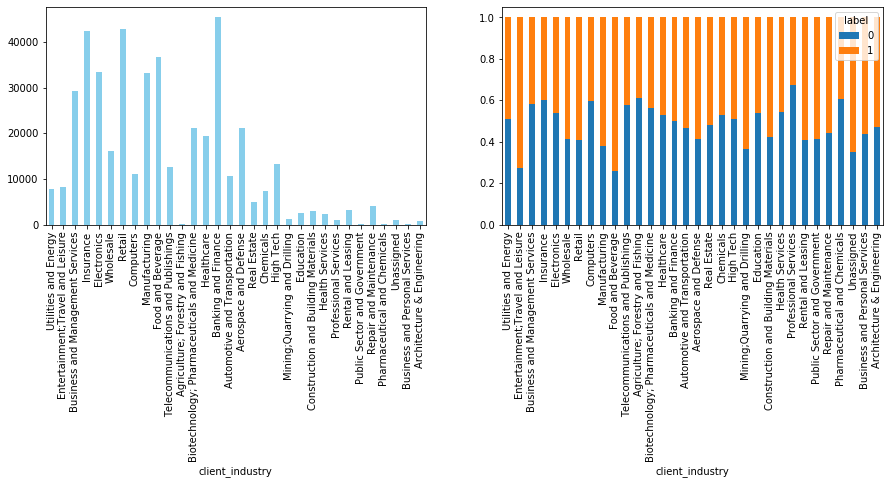

In [15]:
cat_vs_cat_plot('client_industry')

We will keep client industry as it is for first run. Later we may rollup these to higher level.

In [16]:
agriculture_and_mining = ['Mining;Quarrying and Drilling','Agriculture; Forestry and Fishing']
banking_and_finance = ['Banking and Finance']
business_services = ['Rental and Leasing','Professional Services','Business and Personal Services','Business and Management Services']
computer_service_and_software = ['High Tech','Electronics','Computers']
consumer_misc_product_and_manufacturing = ['Repair and Maintenance']
diversified_manufacturing = ['Real Estate','Manufacturing','Construction and Building Materials','Chemicals','Architecture & Engineering','Aerospace and Defense']
education = ['Education']
food_and_beverage = ['Food and Beverage']
government = ['Public Sector and Government']
healthcare_and_medical = ['Pharmaceutical and Chemicals','Healthcare','Health Services','Biotechnology; Pharmaceuticals and Medicine']
insurance = ['Insurance']
retail = ['Wholesale','Retail']
telecom = ['Telecommunications and Publishings','Telecommunications Services']
transport_and_storage = ['Automotive and Transportation']
travel_recreation_and_leisure = ['Entertainment;Travel and Leisure']
utilities_and_energy = ['Utilities and Energy']
unknown = ['Unassigned','Not Applicable']

In [17]:
df.loc[df['client_industry'].isin(agriculture_and_mining), 'client_industry_rollup'] = 'agriculture_and_mining'
df.loc[df['client_industry'].isin(banking_and_finance), 'client_industry_rollup'] = 'banking_and_finance'
df.loc[df['client_industry'].isin(business_services), 'client_industry_rollup'] = 'business_services'
df.loc[df['client_industry'].isin(computer_service_and_software), 'client_industry_rollup'] = 'computer_service_and_software'
df.loc[df['client_industry'].isin(consumer_misc_product_and_manufacturing), 'client_industry_rollup'] = 'consumer_misc_product_and_manufacturing'
df.loc[df['client_industry'].isin(diversified_manufacturing), 'client_industry_rollup'] = 'diversified_manufacturing'
df.loc[df['client_industry'].isin(education), 'client_industry_rollup'] = 'education'
df.loc[df['client_industry'].isin(food_and_beverage), 'client_industry_rollup'] = 'food_and_beverage'
df.loc[df['client_industry'].isin(government), 'client_industry_rollup'] = 'government'
df.loc[df['client_industry'].isin(healthcare_and_medical), 'client_industry_rollup'] = 'healthcare_and_medical'
df.loc[df['client_industry'].isin(insurance), 'client_industry_rollup'] = 'insurance'
df.loc[df['client_industry'].isin(retail), 'client_industry_rollup'] = 'retail'
df.loc[df['client_industry'].isin(telecom), 'client_industry_rollup'] = 'telecom'
df.loc[df['client_industry'].isin(transport_and_storage), 'client_industry_rollup'] = 'transport_and_storage'
df.loc[df['client_industry'].isin(travel_recreation_and_leisure), 'client_industry_rollup'] = 'travel_recreation_and_leisure'
df.loc[df['client_industry'].isin(utilities_and_energy), 'client_industry_rollup'] = 'utilities_and_energy'
df.loc[df['client_industry'].isin(unknown), 'client_industry_rollup'] = 'Unknown'
df.loc[df['client_industry'].isnull(), 'client_industry_rollup'] = 'Unknown'

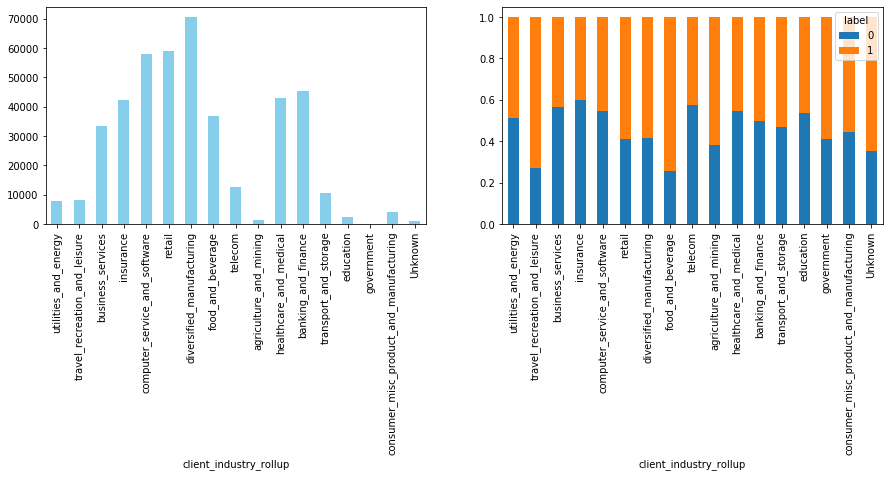

In [18]:
cat_vs_cat_plot('client_industry_rollup')

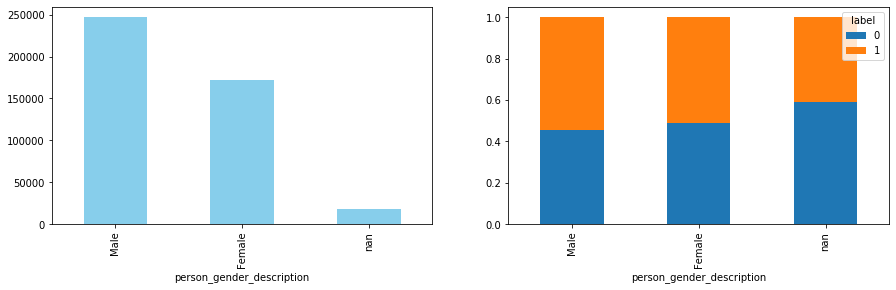

In [19]:
cat_vs_cat_plot('person_gender_description')

We will be imputing missing values (nan values) with "Unknown" value for now.

In [20]:
df['person_gender_description'].fillna('Unknown', inplace=True)

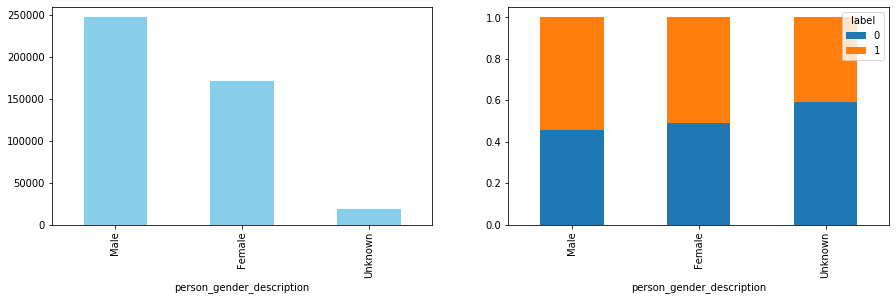

In [21]:
cat_vs_cat_plot('person_gender_description')

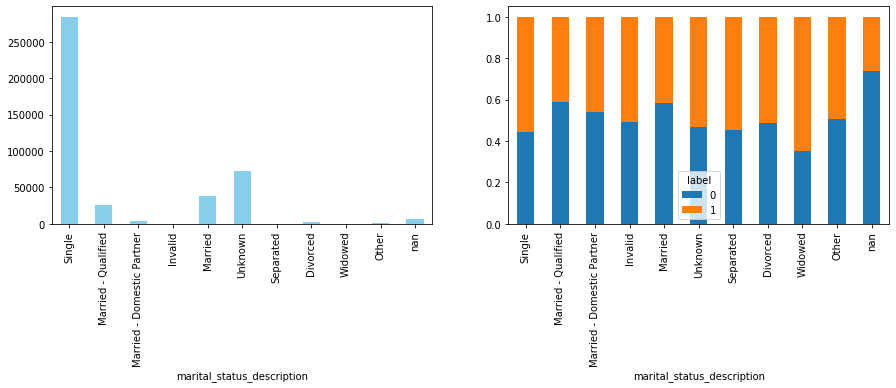

In [22]:
cat_vs_cat_plot('marital_status_description')

We will keep marital status values as it is for the first run of model, at later stage we may do some rollups.

Also, we will be imputing missing values (nan values) with "Unknown" value for now.

In [23]:
df['marital_status_description'].value_counts()

Single                        284393
Unknown                        73124
Married                        38788
Married - Qualified            25131
Married - Domestic Partner      3325
Divorced                        3047
Other                           1442
Separated                        316
Widowed                          315
Invalid                           61
Name: marital_status_description, dtype: int64

In [24]:
single_list = ['Single']
married_list = ['Married','Married - Qualified','Married - Domestic Partner']
divorce_list = ['Divorced','Separated','Widowed']
unknown_list = ['Unknown','Other','Invalid']

In [25]:
df.loc[df['marital_status_description'].isin(single_list), 'marital_status_rollup'] = 'Single'
df.loc[df['marital_status_description'].isin(married_list), 'marital_status_rollup'] = 'Married'
df.loc[df['marital_status_description'].isin(divorce_list), 'marital_status_rollup'] = 'Divorce'
df.loc[df['marital_status_description'].isin(unknown_list), 'marital_status_rollup'] = 'Unknown'
df.loc[df['marital_status_description'].isnull(), 'marital_status_rollup'] = 'Unknown'

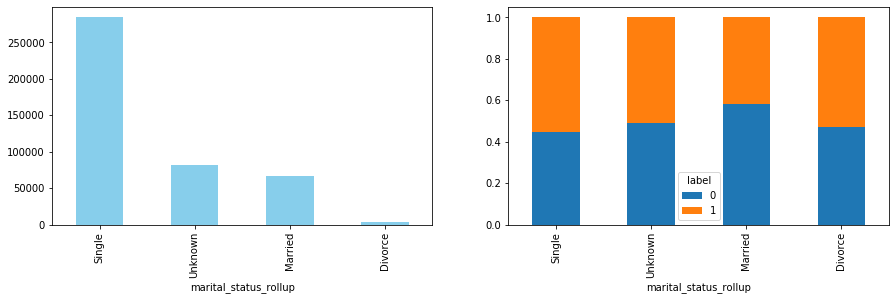

In [26]:
cat_vs_cat_plot('marital_status_rollup')

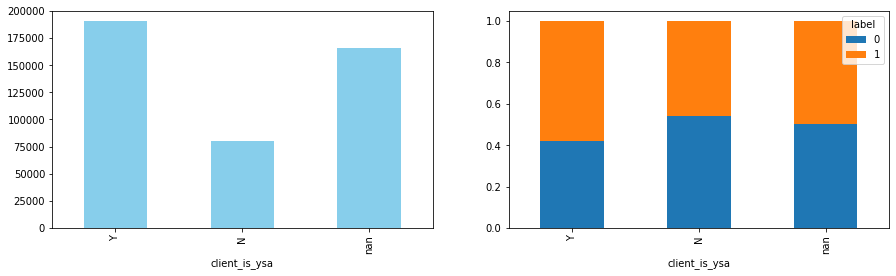

In [27]:
cat_vs_cat_plot('client_is_ysa')

In [28]:
df[df['client_is_ysa'].isnull()]['source_system'].value_counts()

CBA    165934
Name: source_system, dtype: int64

It seems for CBA clients values in `client_is_ysa` does not populate. Imputting missing values with "Unknown"

In [29]:
df['client_is_ysa'].fillna('Unknown', inplace=True)

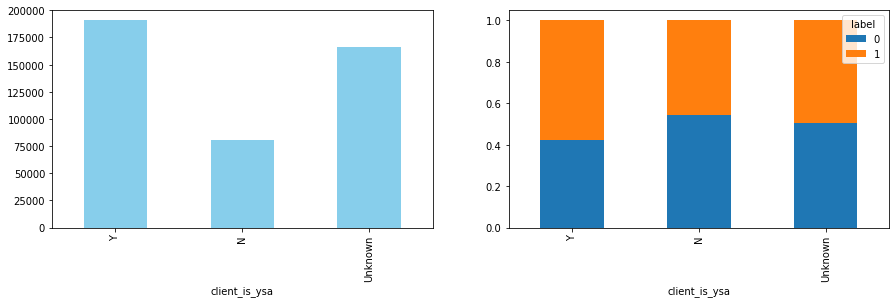

In [30]:
cat_vs_cat_plot('client_is_ysa')

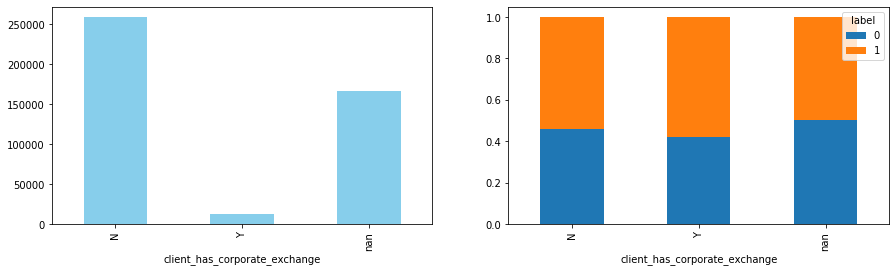

In [31]:
cat_vs_cat_plot('client_has_corporate_exchange')

In [32]:
df[df['client_has_corporate_exchange'].isnull()]['source_system'].value_counts()

CBA    165934
Name: source_system, dtype: int64

It seems for CBA clients values in `client_is_ysa` does not populate. Imputting missing values with "Unknown"

In [33]:
df['client_has_corporate_exchange'].fillna('Unknown', inplace=True)

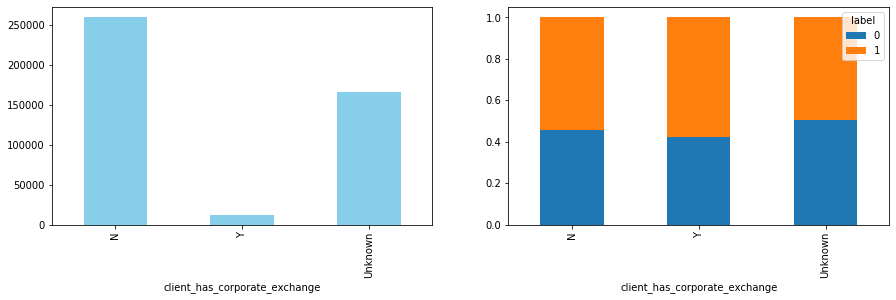

In [34]:
cat_vs_cat_plot('client_has_corporate_exchange')

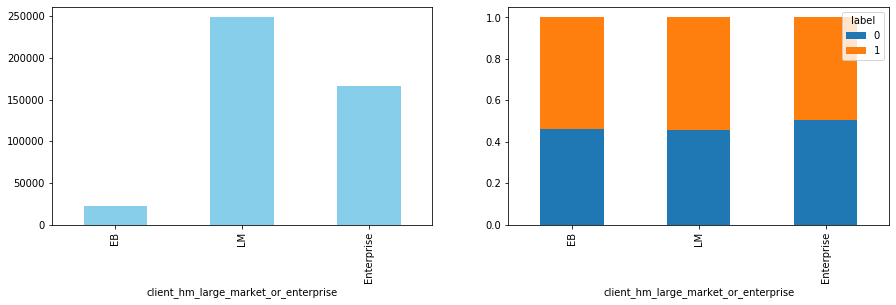

In [35]:
cat_vs_cat_plot('client_hm_large_market_or_enterprise')

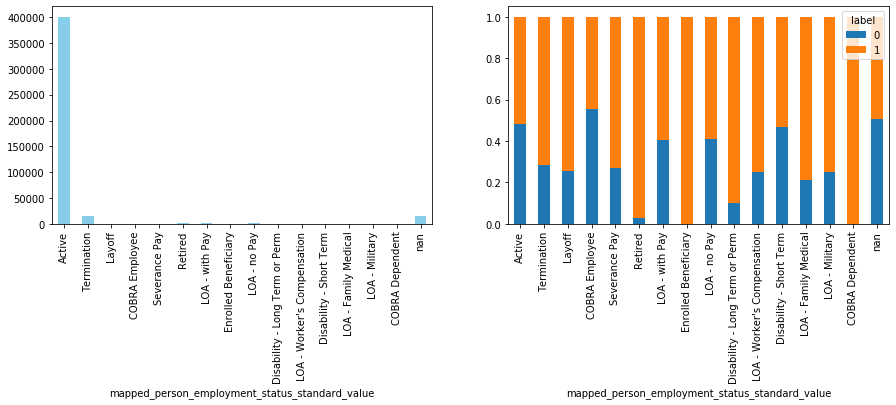

In [36]:
cat_vs_cat_plot('mapped_person_employment_status_standard_value')

We will keep employment status values as it is for the first run of model, at later stage we may do some rollups.

Also, we will be imputing missing values (nan values) with "Unknown" value for now.

In [37]:
df['mapped_person_employment_status_standard_value'].value_counts()

Active                            400813
Termination                        14834
LOA - no Pay                        1898
Retired                             1430
LOA - with Pay                      1305
Disability - Short Term              388
Severance Pay                        367
Layoff                               214
Enrolled Beneficiary                  92
COBRA Employee                        38
LOA - Family Medical                  19
Disability - Long Term or Perm        10
LOA - Worker's Compensation            4
LOA - Military                         4
COBRA Dependent                        1
Name: mapped_person_employment_status_standard_value, dtype: int64

In [38]:
active_list = ['Active','Disability - Long Term or Perm','Disability - Short Term','LOA - Family Medical','LOA - Military','LOA - no Pay','LOA - with Pay',"LOA - Worker's Compensation"]
inactive_list = ['COBRA Employee','Deceased - In Service','Deceased - Out-of-Service','Layoff','Retired','Severance Pay','Termination']
non_employee_list = ['COBRA Dependent','Enrolled Beneficiary','Enrolled QDRO']

In [39]:
df.loc[df['mapped_person_employment_status_standard_value'].isin(active_list), 'employment_status_rollup'] = 'Active'
df.loc[df['mapped_person_employment_status_standard_value'].isin(inactive_list), 'employment_status_rollup'] = 'Inactive'
df.loc[df['mapped_person_employment_status_standard_value'].isin(non_employee_list), 'employment_status_rollup'] = 'Non-Employee'
df.loc[df['mapped_person_employment_status_standard_value'].isnull(), 'employment_status_rollup'] = 'Unknown'

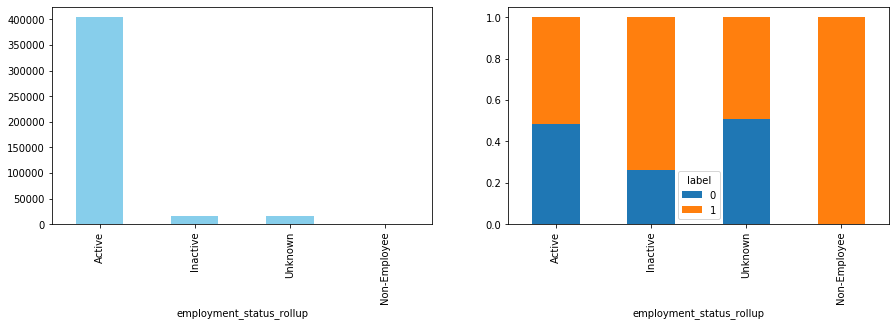

In [40]:
cat_vs_cat_plot('employment_status_rollup')

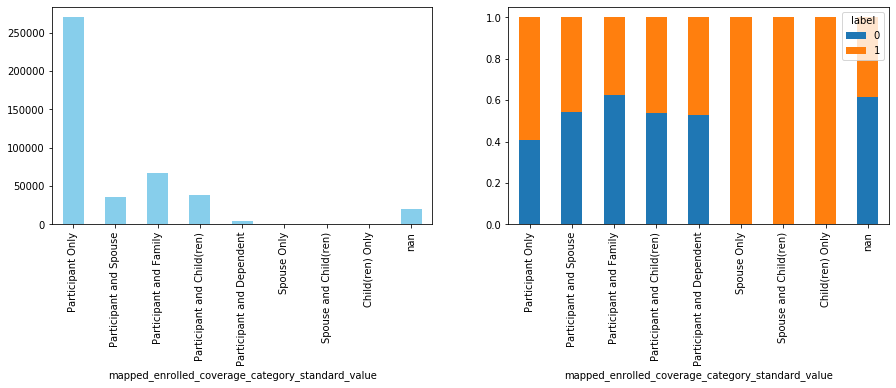

In [41]:
cat_vs_cat_plot('mapped_enrolled_coverage_category_standard_value')

We will keep coverage category values as it is for the first run of model, at later stage we may do some rollups.

Also, we will be imputing missing values (nan values) with "Unknown" value for now.

In [42]:
df['mapped_enrolled_coverage_category_standard_value'].value_counts()

Participant Only              270116
Participant and Family         66611
Participant and Child(ren)     38896
Participant and Spouse         36172
Participant and Dependent       4009
Spouse Only                      231
Spouse and Child(ren)             27
Child(ren) Only                   11
Name: mapped_enrolled_coverage_category_standard_value, dtype: int64

In [43]:
covering_self_list = ['Participant Only']
covering_family_list = ['Participant and Family','Participant and Child(ren)','Participant and Spouse','Participant and Dependent']
covering_others = ['Spouse Only','Spouse and Child(ren)','Child(ren) Only']

In [44]:
df.loc[df['mapped_enrolled_coverage_category_standard_value'].isin(covering_self_list), 'coverage_category_rollup'] = 'Covering_Self'
df.loc[df['mapped_enrolled_coverage_category_standard_value'].isin(covering_family_list), 'coverage_category_rollup'] = 'Covering_Family'
df.loc[df['mapped_enrolled_coverage_category_standard_value'].isin(covering_others), 'coverage_category_rollup'] = 'Covering_Others'
df.loc[df['mapped_enrolled_coverage_category_standard_value'].isnull(), 'coverage_category_rollup'] = 'Unknown'

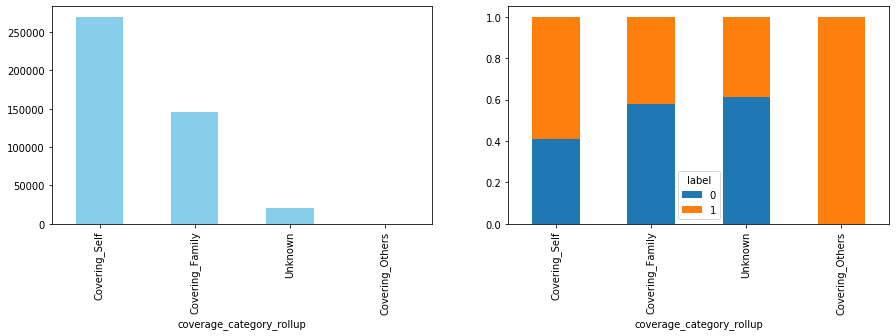

In [45]:
cat_vs_cat_plot('coverage_category_rollup')

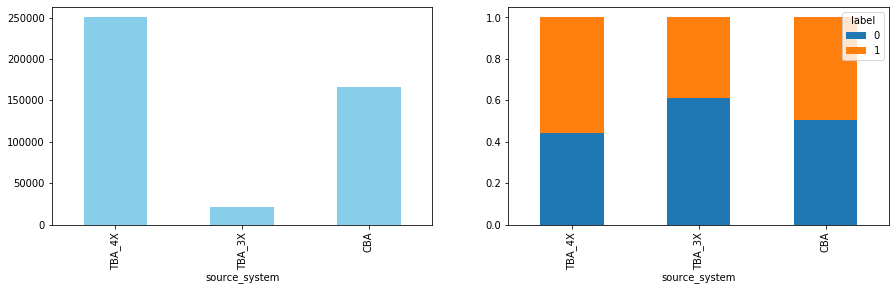

In [46]:
cat_vs_cat_plot('source_system')

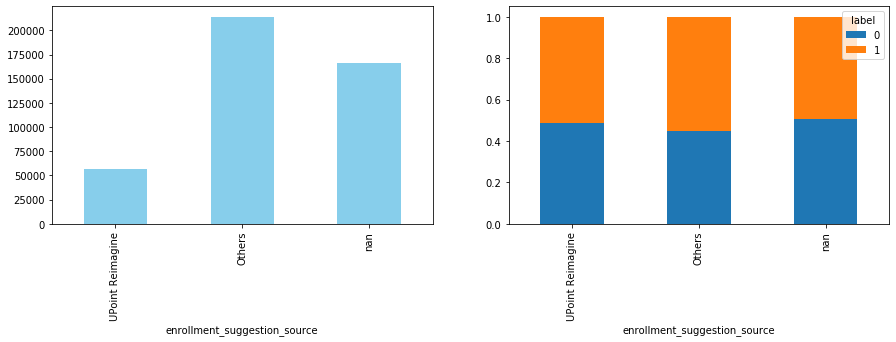

In [47]:
cat_vs_cat_plot('enrollment_suggestion_source')

In [48]:
df[df['enrollment_suggestion_source'].isnull()]['source_system'].value_counts()

CBA    165934
Name: source_system, dtype: int64

It seems for CBA clients values in `enrollment_suggestion_source` does not populate. Imputting missing values with "Unknown"

In [49]:
df['enrollment_suggestion_source'].fillna('Unknown', inplace=True)

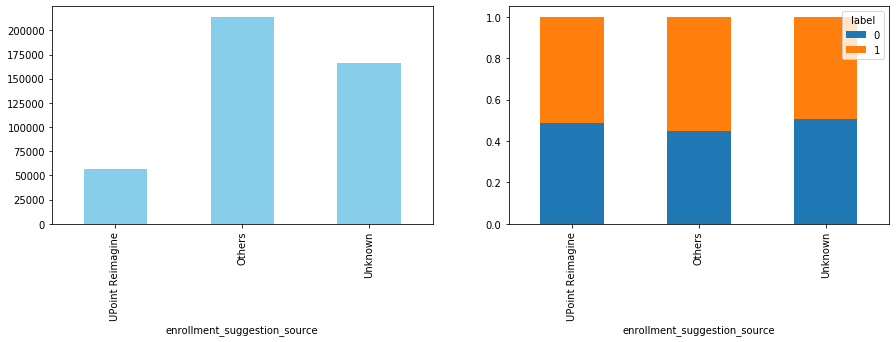

In [50]:
cat_vs_cat_plot('enrollment_suggestion_source')

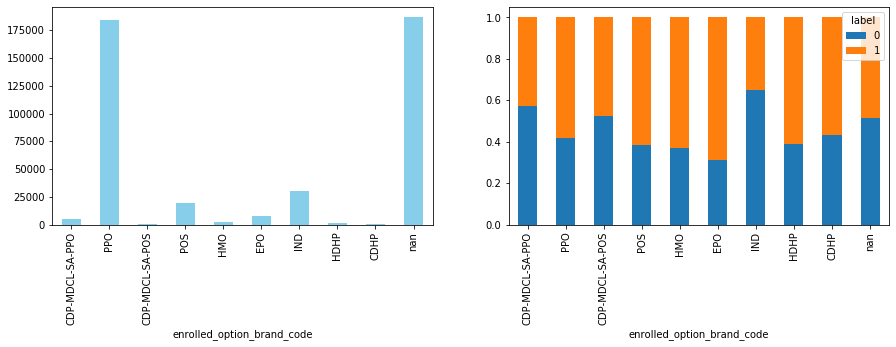

In [51]:
cat_vs_cat_plot('enrolled_option_brand_code')

In [52]:
df[df['enrolled_option_brand_code'].isnull()]['source_system'].value_counts()

CBA       165934
TBA_3X     20590
TBA_4X       107
Name: source_system, dtype: int64

In [53]:
df[df['enrolled_option_description_group'].isnull()]['source_system'].value_counts()

TBA_4X    250195
TBA_3X     20590
Name: source_system, dtype: int64

In [54]:
df['source_system'].value_counts()

TBA_4X    250195
CBA       165934
TBA_3X     20590
Name: source_system, dtype: int64

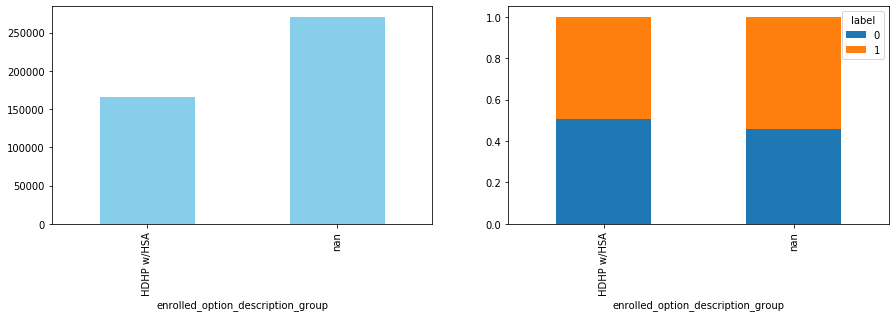

In [55]:
cat_vs_cat_plot('enrolled_option_description_group')

In [56]:
df.loc[
    df['source_system']=='CBA'
    ,'enrolled_option_bc_dg'
] = df['enrolled_option_description_group']

df.loc[
    df['source_system']!='CBA'
    ,'enrolled_option_bc_dg'
] = df['enrolled_option_brand_code']

In [57]:
df[df['enrolled_option_bc_dg'].isnull()]['source_system'].value_counts()

TBA_3X    20590
TBA_4X      107
Name: source_system, dtype: int64

In [58]:
df['enrolled_option_bc_dg'].fillna('Unknown', inplace=True)

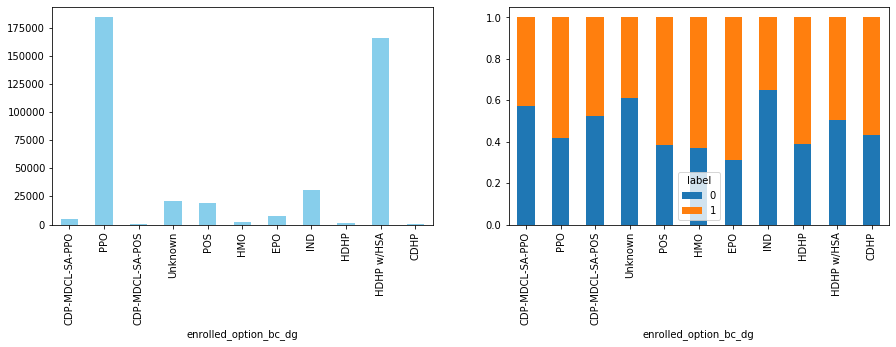

In [59]:
cat_vs_cat_plot('enrolled_option_bc_dg')

Values for CBA clients are getting captured in `enrolled_option_description_group` column while for TBA_4X values are getting captured in `enrolled_option_brand_code`.

We will be imputing missing values (nan values) with "Unknown" value for now.

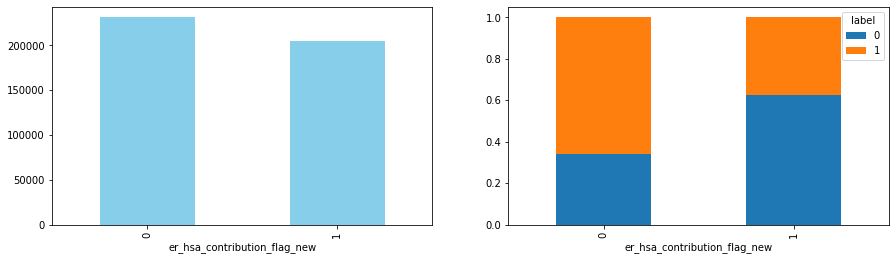

In [60]:
cat_vs_cat_plot('er_hsa_contribution_flag_new')

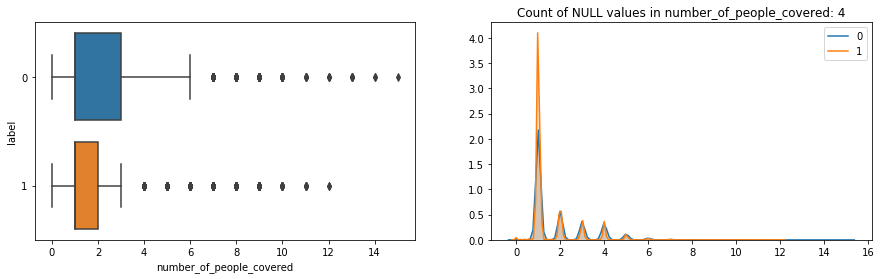

In [61]:
cat_vs_cont_plot('number_of_people_covered')

We will keep outlier as it is for first run, later we will handle outliers if required.
Also, will impute missing values with median after train and test split.

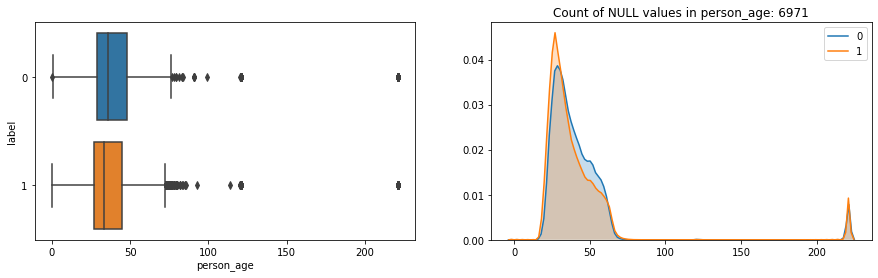

In [62]:
cat_vs_cont_plot('person_age')

In [63]:
df[df['person_age']<18].shape

(84, 30)

Observations - 
1. We can see cases where age is less than 18 years, we will cap them to 18 years
2. There are many outliers in the column, we will cap the outliers to 95th or 99th percentile based on person's employment status. 
3. There are some cases where age is missing, we will be imputing null values using median.
4. We will scale this column to 0 - 1 to keep values of all columns on same scale

We will perform step 2, 3, and 4 after splitting dataset into training set and testing set and use training dataset to cap outliers, impute missing values, and scale column.

In [64]:
df.loc[
    df['person_age'] < 18,
    'person_age'
] = 18

In [65]:
df['person_age'].min()

18.0

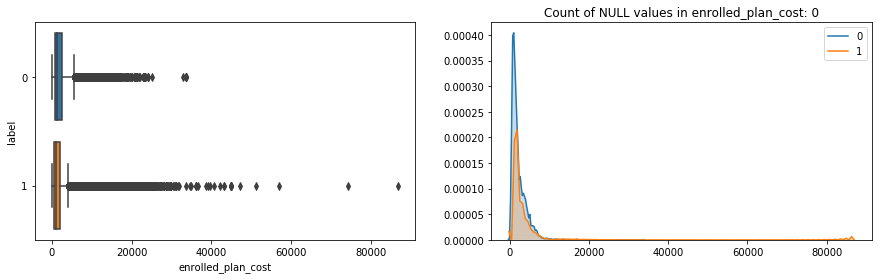

In [66]:
cat_vs_cont_plot('enrolled_plan_cost')

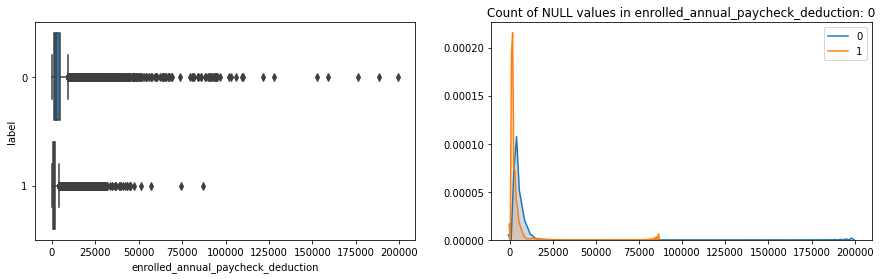

In [67]:
cat_vs_cont_plot('enrolled_annual_paycheck_deduction')

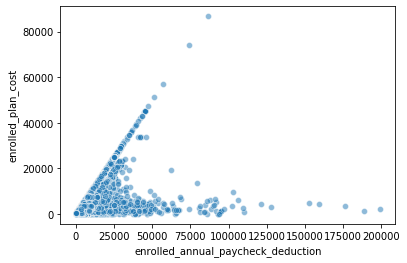

In [68]:
sns.scatterplot(data=df, x='enrolled_annual_paycheck_deduction', y='enrolled_plan_cost', alpha=0.5)

In [69]:
df[['enrolled_annual_paycheck_deduction','enrolled_plan_cost']].corr()

,enrolled_annual_paycheck_deduction,enrolled_plan_cost
enrolled_annual_paycheck_deduction,1.000000,0.761309
enrolled_plan_cost,0.761309,1.000000


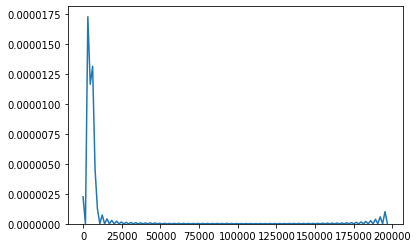

In [70]:
sns.kdeplot(abs(df['enrolled_annual_paycheck_deduction']-df['enrolled_plan_cost']))

Observations - 
- We can see that`enrolled_annual_paycheck_deduction` and `enrolled_plan_cost` are highly correlated
- Also, absoulte difference between the two is mostly close to zero
- We will be using one column only for modelling which will be `enrolled_plan_cost`
- We can see there are many outliers in both the columns, we will keep them as it is.
- We will scale this column to 0 - 1 to keep values of all columns on same scale. We will perform this step after splitting dataset into training set and testing set and use training dataset to scale column. 

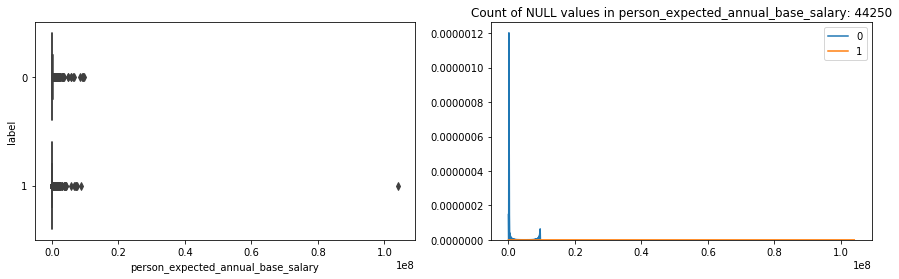

In [71]:
cat_vs_cont_plot('person_expected_annual_base_salary')

In [72]:
df['person_expected_annual_base_salary'].describe().astype(int)

count       392469
mean         72428
std         185116
min              0
25%          36545
50%          51257
75%          90000
max      104000000
Name: person_expected_annual_base_salary, dtype: int64

In [73]:
df['person_expected_annual_base_salary'].quantile(.95)

170000.0

In [74]:
df[df['enrolled_plan_cost']>df['enrolled_plan_cost'].quantile(.95)].shape

(21764, 30)

We can observe the data is highly skewed and have outliers. Instead of using this column directly in the model, we will create `person_expected_annual_base_salary_range` column and use this new column.

In [75]:
df['person_expected_annual_base_salary'].min()

0.0

In [76]:
bins = [-1, 19999, 39999, 59999, 79999, 99999, 999999999999]
labels = ['<20,000', '20,000 - 39,999', '40,000 - 59,999', '60,000 - 79,999', '80,000 - 99,999', '100,000+']
df['person_expected_annual_base_salary_range'] = pd.cut(x=df['person_expected_annual_base_salary'], bins=bins, labels=labels)

In [77]:
df[df['person_expected_annual_base_salary'].isnull()].shape

(44250, 31)

In [78]:
df[df['person_expected_annual_base_salary_range'].isnull()].shape

(44250, 31)

In [79]:
df['person_expected_annual_base_salary_range'] = df['person_expected_annual_base_salary_range'].astype(str)
df['person_expected_annual_base_salary_range'].replace(to_replace='nan',value='Unknown', inplace=True)

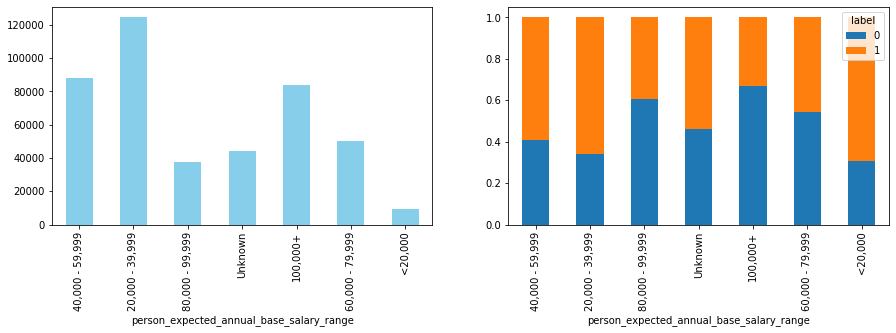

In [80]:
cat_vs_cat_plot('person_expected_annual_base_salary_range')

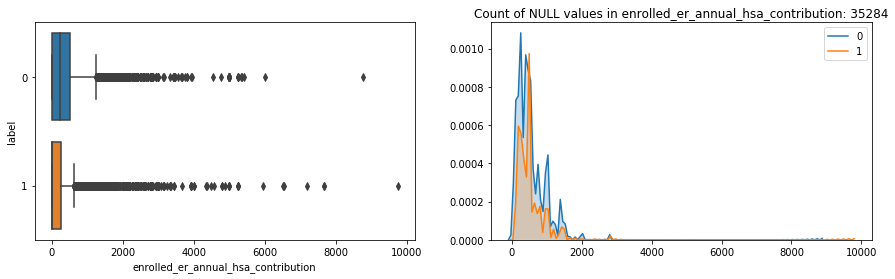

In [81]:
cat_vs_cont_plot('enrolled_er_annual_hsa_contribution')

1. We can observe outliers in this variable, however we will keep them as it is for now.
2. Since there are missing values, we will impute it using median.
3. We will scale this column to 0 - 1 to keep values of all columns on same scale.

We will perform steps 2 & 3 after splitting dataset into training set and testing set and use training dataset to impute missing values, and scale column. 

In [82]:
df.isnull().sum()

platform_id                                              0
client_id                                                0
client_name                                              0
client_industry                                          0
platform_person_internal_id                              0
enrolled_option_description                          19181
enrolled_plan_cost                                       0
enrolled_annual_paycheck_deduction                       0
person_age                                            6971
person_gender_description                                0
marital_status_description                            6777
person_expected_annual_base_salary                   44250
client_is_ysa                                            0
client_has_corporate_exchange                            0
client_hm_large_market_or_enterprise                     0
number_of_people_covered                                 4
enrolled_er_annual_hsa_contribution                  352

At this stage, we are done with following steps - 
- Imouted NULL values for categorical variables with 'Unknown'
- Capped age < 18 years to 18 years


Next Steps - 
- Drop columns not required for modeling
- Split the dataset into two parts Training Set (70%) and Testing Set(30%). Once completed then perform below steps
- Impute missing values byr median for numerical variables using training set
- Scale numerical varilables using Min-Max scalar
- Encode categorical features
- Data Modeling, Predcitions, Model Evaluation

In [83]:
df['label'].value_counts(normalize=True, dropna=False)

1    0.525113
0    0.474887
Name: label, dtype: float64

Target variable seems to be balanced, we will use startified random 

In [84]:
df.head(3)

,platform_id,client_id,client_name,client_industry,platform_person_internal_id,enrolled_option_description,enrolled_plan_cost,enrolled_annual_paycheck_deduction,person_age,person_gender_description,marital_status_description,person_expected_annual_base_salary,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,mapped_person_employment_status_standard_value,mapped_enrolled_coverage_category_standard_value,source_system,enrollment_suggestion_source,enrolled_option_brand_code,enrolled_option_description_group,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range
0,10021,9264,Stericycle; Inc.,Utilities and Energy,10021/100070010,HSA Basic Choice Plus,843.0,843.36,19.0,Male,Single,47840.0,Y,N,EB,1.0,0.0,Active,Participant Only,TBA_4X,UPoint Reimagine,CDP-MDCL-SA-PPO,NaN,0,1,utilities_and_energy,Single,Active,Covering_Self,CDP-MDCL-SA-PPO,"40,000 - 59,999"
1,10021,10801,Expedia; Inc.,Entertainment;Travel and Leisure,10021/100390006,Aetna Health Savings Plan,2076.0,2076.00,28.0,Female,Single,57000.0,N,N,EB,2.0,1500.0,Active,Participant and Spouse,TBA_4X,Others,PPO,NaN,1,1,travel_recreation_and_leisure,Single,Active,Covering_Family,PPO,"40,000 - 59,999"
2,10021,16516,PayPal,Business and Management Services,10021/100390027,UHC CDHP with HSA,598.0,598.00,28.0,Female,Single,35360.0,Y,N,EB,1.0,500.0,Active,Participant Only,TBA_4X,Others,CDP-MDCL-SA-PPO,NaN,1,1,business_services,Single,Active,Covering_Self,CDP-MDCL-SA-PPO,"20,000 - 39,999"


In [85]:
drop_columns = ['platform_id','client_id','client_name','platform_person_internal_id','enrolled_option_description',
                'enrolled_annual_paycheck_deduction','enrolled_option_brand_code','enrolled_option_description_group',
                'client_industry','marital_status_description','person_expected_annual_base_salary',
                 'mapped_person_employment_status_standard_value','mapped_enrolled_coverage_category_standard_value']

df_final = df.drop(columns=drop_columns)
df_final.shape

(436719, 18)

In [86]:
df_final.dtypes

enrolled_plan_cost                          float64
person_age                                  float64
person_gender_description                    object
client_is_ysa                                object
client_has_corporate_exchange                object
client_hm_large_market_or_enterprise         object
number_of_people_covered                    float64
enrolled_er_annual_hsa_contribution         float64
source_system                                object
enrollment_suggestion_source                 object
er_hsa_contribution_flag_new                  int64
label                                         int64
client_industry_rollup                       object
marital_status_rollup                        object
employment_status_rollup                     object
coverage_category_rollup                     object
enrolled_option_bc_dg                        object
person_expected_annual_base_salary_range     object
dtype: object

In [87]:
cat_columns = ['client_industry_rollup','person_gender_description','marital_status_rollup','client_is_ysa',
               'client_has_corporate_exchange','client_hm_large_market_or_enterprise','employment_status_rollup',
               'coverage_category_rollup','source_system','enrollment_suggestion_source','er_hsa_contribution_flag_new',
               'enrolled_option_bc_dg','person_expected_annual_base_salary_range']
num_columns = ['person_age','number_of_people_covered','enrolled_plan_cost','enrolled_er_annual_hsa_contribution']
print(len(cat_columns))
print(len(num_columns))

13
4


In [88]:
df_final[cat_columns] = df_final[cat_columns].fillna("Unknown")

df_final[cat_columns].isnull().sum()

client_industry_rollup                      0
person_gender_description                   0
marital_status_rollup                       0
client_is_ysa                               0
client_has_corporate_exchange               0
client_hm_large_market_or_enterprise        0
employment_status_rollup                    0
coverage_category_rollup                    0
source_system                               0
enrollment_suggestion_source                0
er_hsa_contribution_flag_new                0
enrolled_option_bc_dg                       0
person_expected_annual_base_salary_range    0
dtype: int64

In [89]:
df_final[num_columns].isna().sum()

person_age                              6971
number_of_people_covered                   4
enrolled_plan_cost                         0
enrolled_er_annual_hsa_contribution    35284
dtype: int64

In [90]:
df_final.shape

(436719, 18)

### Splitting the dataset into training and testing set

In [268]:
train_set, test_set = train_test_split(df_final, test_size=0.3, shuffle=True, random_state=42, stratify=df_final['label'])

In [269]:
train_set.shape

(305703, 18)

In [270]:
test_set.shape

(131016, 18)

In [271]:
train_set['label'].value_counts(normalize=True)

1    0.525114
0    0.474886
Name: label, dtype: float64

In [272]:
test_set['label'].value_counts(normalize=True)

1    0.525111
0    0.474889
Name: label, dtype: float64

In [273]:
train_set.isna().sum()

enrolled_plan_cost                              0
person_age                                   4903
person_gender_description                       0
client_is_ysa                                   0
client_has_corporate_exchange                   0
client_hm_large_market_or_enterprise            0
number_of_people_covered                        3
enrolled_er_annual_hsa_contribution         24737
source_system                                   0
enrollment_suggestion_source                    0
er_hsa_contribution_flag_new                    0
label                                           0
client_industry_rollup                          0
marital_status_rollup                           0
employment_status_rollup                        0
coverage_category_rollup                        0
enrolled_option_bc_dg                           0
person_expected_annual_base_salary_range        0
dtype: int64

In [274]:
test_set.isna().sum()

enrolled_plan_cost                              0
person_age                                   2068
person_gender_description                       0
client_is_ysa                                   0
client_has_corporate_exchange                   0
client_hm_large_market_or_enterprise            0
number_of_people_covered                        1
enrolled_er_annual_hsa_contribution         10547
source_system                                   0
enrollment_suggestion_source                    0
er_hsa_contribution_flag_new                    0
label                                           0
client_industry_rollup                          0
marital_status_rollup                           0
employment_status_rollup                        0
coverage_category_rollup                        0
enrolled_option_bc_dg                           0
person_expected_annual_base_salary_range        0
dtype: int64

In [275]:
age_upper_cap = train_set.groupby(['employment_status_rollup'])['person_age'].quantile(0.95).reset_index()
age_upper_cap.rename(columns={'person_age':'upper_age_cap'},inplace=True)
age_upper_cap

,employment_status_rollup,upper_age_cap
0,Active,60.0
1,Inactive,64.0
2,Non-Employee,67.1
3,Unknown,221.0


In [276]:
age_cap_unknon = train_set[train_set['employment_status_rollup']=='Unknown']['person_age'].quantile(0.75)
age_cap_unknon

63.0

In [277]:
age_upper_cap.loc[age_upper_cap['employment_status_rollup']=='Unknown', 'upper_age_cap'] = age_cap_unknon
age_upper_cap

,employment_status_rollup,upper_age_cap
0,Active,60.0
1,Inactive,64.0
2,Non-Employee,67.1
3,Unknown,63.0


In [278]:
train_set = train_set.merge(age_upper_cap, how='left', on='employment_status_rollup')
train_set.shape

(305703, 19)

In [279]:
train_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,0.0,31.0,Male,Y,N,LM,1.0,1700.0,TBA_3X,Others,1,1,healthcare_and_medical,Married,Active,Unknown,Unknown,Unknown,60.0
1,1063.0,25.0,Female,Unknown,Unknown,Enterprise,1.0,0.0,CBA,Unknown,0,0,business_services,Single,Active,Covering_Self,HDHP w/HSA,"80,000 - 99,999",60.0


In [280]:
train_set['person_age'] = np.where(train_set['person_age'] > train_set['upper_age_cap'], train_set['upper_age_cap'], train_set['person_age'])
train_set.shape

(305703, 19)

In [281]:
train_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,0.0,31.0,Male,Y,N,LM,1.0,1700.0,TBA_3X,Others,1,1,healthcare_and_medical,Married,Active,Unknown,Unknown,Unknown,60.0
1,1063.0,25.0,Female,Unknown,Unknown,Enterprise,1.0,0.0,CBA,Unknown,0,0,business_services,Single,Active,Covering_Self,HDHP w/HSA,"80,000 - 99,999",60.0


In [282]:
train_set.drop(columns='upper_age_cap', inplace=True)

In [283]:
class CustomNumericImputer:
    
    def __init__(self):
        return None
    
    def fit(self, X, impute_cols, using_cols, method='median'):
        self.using_cols = using_cols
        self.impute_cols = impute_cols
        self.method = method
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        
        if self.method == 'median':
            self.fit_values = X_.groupby(using_cols)[impute_cols].median().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_median') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.median(), inplace=True)
        elif self.method == 'mean':
            self.fit_values = X_.groupby(using_cols)[impute_cols].mean().reset_index()
            impute_cols_rename_dict = dict([(x,x+'_mean') for x in self.impute_cols])
            self.fit_values.rename(columns=impute_cols_rename_dict, inplace=True)
            self.fit_values.fillna(self.fit_values.mean(), inplace=True)
        else: print('Method can be "median" or "mean"')
        self.new_cols = list(impute_cols_rename_dict.values())
        return self
    
    def fit_transform(self, X, impute_cols, using_cols, method='median'):
        self.fit(X, impute_cols, using_cols, method)
        
        cols = self.using_cols + self.impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols, self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
    
    def transform(self, X, impute_cols):
        cols = self.using_cols + impute_cols
        X_ = X[cols]
        X_ = X_.merge(self.fit_values, how='left', on=self.using_cols)
        for col, ncol in zip(self.impute_cols,self.new_cols):
            X_[col] = np.where(X_[col].isnull(), X_[ncol], X_[col])
            
        if self.method == 'median':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].median())
        elif self.method == 'mean':
            return X_[self.impute_cols].fillna(X_[self.impute_cols].mean())
         

In [284]:
train_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,300800.000000,305700.000000,305703.000000,280966.000000
mean,37.582372,1.685675,1814.599072,261.742764
std,11.884628,1.189925,2148.581459,384.797521
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,663.000000,0.000000
50%,35.000000,1.000000,1196.000000,50.000000
75%,46.000000,2.000000,2249.000000,425.000000
max,67.100000,14.000000,86720.000000,9750.000000


In [285]:
custom_numeric_imputer = CustomNumericImputer()

In [286]:
train_set[num_columns] = custom_numeric_imputer.fit_transform(X=train_set, impute_cols=num_columns,
                                                              using_cols=['employment_status_rollup'], method='median')

In [287]:
train_set[num_columns].isnull().sum()

person_age                             0
number_of_people_covered               0
enrolled_plan_cost                     0
enrolled_er_annual_hsa_contribution    0
dtype: int64

In [288]:
train_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,305703.000000,305703.000000,305703.000000,305703.000000
mean,37.548547,1.685669,1814.599072,243.955972
std,11.795470,1.189921,2148.581459,373.759812
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,663.000000,0.000000
50%,35.000000,1.000000,1196.000000,41.000000
75%,46.000000,2.000000,2249.000000,400.000000
max,67.100000,14.000000,86720.000000,9750.000000


In [289]:
custom_numeric_imputer.fit_values

,employment_status_rollup,person_age_median,number_of_people_covered_median,enrolled_plan_cost_median,enrolled_er_annual_hsa_contribution_median
0,Active,34.0,1.0,1196.0,41.0
1,Inactive,46.0,1.0,1851.0,40.0
2,Non-Employee,56.0,1.0,924.0,0.0
3,Unknown,39.0,1.0,832.0,200.0


In [290]:
train_set.shape

(305703, 18)

In [291]:
train_set = pd.concat([pd.get_dummies(data=train_set.drop(columns='label'), columns=cat_columns, drop_first=True), train_set[['label']]], axis=1)
train_set.shape

(305703, 59)

### 4. Imputing missing values, handling outlier and encoding categorical variables (Testing Set)

In [250]:
test_set = test_set.merge(age_upper_cap, how='left', on='employment_status_rollup')
test_set.shape

(131016, 19)

In [251]:
test_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range,upper_age_cap
0,0.0,32.0,Female,Y,N,LM,1.0,62.5,TBA_3X,Others,1,1,business_services,Single,Active,Unknown,Unknown,"100,000+",60.0
1,7330.0,49.0,Male,Unknown,Unknown,Enterprise,5.0,1500.0,CBA,Unknown,1,0,healthcare_and_medical,Unknown,Active,Covering_Family,HDHP w/HSA,"<20,000",60.0


In [252]:
test_set['person_age'] = np.where(test_set['person_age'] > test_set['upper_age_cap'], test_set['upper_age_cap'], test_set['person_age'])
test_set.shape

(131016, 19)

In [253]:
test_set.drop(columns='upper_age_cap', inplace=True)
test_set.shape

(131016, 18)

In [254]:
test_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,128948.000000,131015.000000,131016.000000,120469.000000
mean,37.525244,1.686303,1812.140616,261.155836
std,11.889092,1.189575,2154.227361,383.603779
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,660.000000,0.000000
50%,35.000000,1.000000,1184.000000,50.000000
75%,46.000000,2.000000,2249.000000,417.000000
max,67.100000,15.000000,47175.000000,6509.880000


In [255]:
test_set[num_columns] = custom_numeric_imputer.transform(X=test_set, impute_cols=num_columns)
test_set.shape

(131016, 18)

In [256]:
test_set[num_columns].isnull().sum()

person_age                             0
number_of_people_covered               0
enrolled_plan_cost                     0
enrolled_er_annual_hsa_contribution    0
dtype: int64

In [257]:
test_set[num_columns].describe()

,person_age,number_of_people_covered,enrolled_plan_cost,enrolled_er_annual_hsa_contribution
count,131016.000000,131016.000000,131016.000000,131016.000000
mean,37.492879,1.686298,1812.140616,243.500927
std,11.801133,1.189572,2154.227361,372.666298
min,18.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,660.000000,0.000000
50%,35.000000,1.000000,1184.000000,41.000000
75%,46.000000,2.000000,2249.000000,400.000000
max,67.100000,15.000000,47175.000000,6509.880000


In [258]:
test_set.head(2)

,enrolled_plan_cost,person_age,person_gender_description,client_is_ysa,client_has_corporate_exchange,client_hm_large_market_or_enterprise,number_of_people_covered,enrolled_er_annual_hsa_contribution,source_system,enrollment_suggestion_source,er_hsa_contribution_flag_new,label,client_industry_rollup,marital_status_rollup,employment_status_rollup,coverage_category_rollup,enrolled_option_bc_dg,person_expected_annual_base_salary_range
0,0.0,32.0,Female,Y,N,LM,1.0,62.5,TBA_3X,Others,1,1,business_services,Single,Active,Unknown,Unknown,"100,000+"
1,7330.0,49.0,Male,Unknown,Unknown,Enterprise,5.0,1500.0,CBA,Unknown,1,0,healthcare_and_medical,Unknown,Active,Covering_Family,HDHP w/HSA,"<20,000"


In [259]:
test_set = pd.concat([pd.get_dummies(data=test_set.drop(columns='label'), columns=cat_columns, drop_first=True), test_set[['label']]], axis=1)
test_set.shape

(131016, 59)

In [260]:
test_set = test_set.reindex(columns=train_set.columns, fill_value=0)
test_set.shape

(131016, 59)

In [261]:
test_set.head(2)

,enrolled_plan_cost,person_age,number_of_people_covered,enrolled_er_annual_hsa_contribution,client_industry_rollup_agriculture_and_mining,client_industry_rollup_banking_and_finance,client_industry_rollup_business_services,client_industry_rollup_computer_service_and_software,client_industry_rollup_consumer_misc_product_and_manufacturing,client_industry_rollup_diversified_manufacturing,client_industry_rollup_education,client_industry_rollup_food_and_beverage,client_industry_rollup_government,client_industry_rollup_healthcare_and_medical,client_industry_rollup_insurance,client_industry_rollup_retail,client_industry_rollup_telecom,client_industry_rollup_transport_and_storage,client_industry_rollup_travel_recreation_and_leisure,client_industry_rollup_utilities_and_energy,person_gender_description_Male,person_gender_description_Unknown,marital_status_rollup_Married,marital_status_rollup_Single,marital_status_rollup_Unknown,client_is_ysa_Unknown,client_is_ysa_Y,client_has_corporate_exchange_Unknown,client_has_corporate_exchange_Y,client_hm_large_market_or_enterprise_Enterprise,client_hm_large_market_or_enterprise_LM,employment_status_rollup_Inactive,employment_status_rollup_Non-Employee,employment_status_rollup_Unknown,coverage_category_rollup_Covering_Others,coverage_category_rollup_Covering_Self,coverage_category_rollup_Unknown,source_system_TBA_3X,source_system_TBA_4X,enrollment_suggestion_source_UPoint Reimagine,enrollment_suggestion_source_Unknown,er_hsa_contribution_flag_new_1,enrolled_option_bc_dg_CDP-MDCL-SA-POS,enrolled_option_bc_dg_CDP-MDCL-SA-PPO,enrolled_option_bc_dg_EPO,enrolled_option_bc_dg_HDHP,enrolled_option_bc_dg_HDHP w/HSA,enrolled_option_bc_dg_HMO,enrolled_option_bc_dg_IND,enrolled_option_bc_dg_POS,enrolled_option_bc_dg_PPO,enrolled_option_bc_dg_Unknown,"person_expected_annual_base_salary_range_20,000 - 39,999","person_expected_annual_base_salary_range_40,000 - 59,999","person_expected_annual_base_salary_range_60,000 - 79,999","person_expected_annual_base_salary_range_80,000 - 99,999","person_expected_annual_base_salary_range_<20,000",person_expected_annual_base_salary_range_Unknown,label
0,0.0,32.0,1.0,62.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,7330.0,49.0,5.0,1500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [262]:
train_set.isnull().sum().sum()

0

In [263]:
test_set.isnull().sum().sum()

0

In [264]:
train_set.shape

(305703, 59)

In [265]:
test_set.shape

(131016, 59)

### Exporting transformed data to S3

In [266]:
print(f'Uploading transformed training data here -> s3://{bucket}/{transformed_train_data_path}/data.csv')

train_set.to_csv(f's3://{bucket}/{transformed_train_data_path}/data.csv', index=False)

Uploading transformed training data here -> s3://adl-core-dev-sagemaker-studio/external/amitmittal/HSA/version-1/transformed-data/dpp0/train/data.csv


In [267]:
print(f'Uploading transformed testing data here -> s3://{bucket}/{transformed_test_data_path}/data.csv')

test_set.to_csv(f's3://{bucket}/{transformed_test_data_path}/data.csv', index=False)

Uploading transformed testing data here -> s3://adl-core-dev-sagemaker-studio/external/amitmittal/HSA/version-1/transformed-data/dpp0/test/data.csv
